In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt 
from scipy import signal
from sklearn.cross_decomposition import CCA

## Load Dataset

In [2]:
dataset_name = "sultan_psychopy_recordings/eeg_psychopy_sultan_recording_" # 0 to 3
num_targets = 4
targets = [None] * num_targets
channels = ['P7', 'O1', 'O2', 'P8'] # data channels
for i in range(num_targets):
    targets[i] = pd.read_csv(dataset_name+str(i)+'.csv')
    targets[i]['Unnamed: 0'] = [i % 129 for i in range(len(targets[i].index))]
    targets[i].rename(columns = {'Unnamed: 0': 'Counter'}, inplace=True)
targets[0].head

<bound method NDFrame.head of       Counter        P7        O1        O2        P8          TIME
0           0  4578.462  3935.897  3865.641  4278.462  1.606509e+09
1           1  4569.231  3936.410  3867.692  4274.359  1.606509e+09
2           2  4570.256  3938.462  3856.923  4275.897  1.606509e+09
3           3  4569.231  3935.385  3847.692  4269.744  1.606509e+09
4           4  4577.436  3946.154  3861.538  4270.769  1.606509e+09
...       ...       ...       ...       ...       ...           ...
8995       94  4609.744  3960.513  3878.974  4308.205  1.606509e+09
8996       95  4600.513  3948.718  3870.256  4290.256  1.606509e+09
8997       96  4606.154  3949.231  3871.282  4288.205  1.606509e+09
8998       97  4603.590  3950.769  3873.846  4293.846  1.606509e+09
8999       98  4596.410  3949.231  3872.308  4292.308  1.606509e+09

[9000 rows x 6 columns]>

In [3]:
# check size - make sure each target is the same length
for i in range(num_targets):
    print('length target {} = {}'.format(i, len(targets[i].index)))

length target 0 = 9000
length target 1 = 9000
length target 2 = 9000
length target 3 = 9000


In [4]:
# copy unfiltered data
original_data = [None] * num_targets
for i in range(num_targets):
    original_data[i] = pd.read_csv(dataset_name+str(i)+'.csv')
    original_data[i]['Unnamed: 0'] = [i % 129 for i in range(len(original_data[i].index))]
    original_data[i].rename(columns = {'Unnamed: 0': 'Counter'}, inplace=True)

In [5]:
channels = ['P7', 'O1', 'O2', 'P8']
my_colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:cyan', 'tab:gray']
my_labels = ['Target 0', 'Target 1', 'Target 2', 'Target 3', 'Target 4', 'Target 5', 'Target 6', 'Target 7', 'Neutral Target']

def fir_filter_by_chunk(frequencies=None, num_seconds=3):
    # filtered list of lists
    cols = ['Counter', 'O1', 'O2', 'P7', 'P8']
    row_index = 0
    # filtered_pd = pd.DataFrame(columns = cols)
    filtered = [None] * num_targets
    if frequencies is None:
        filt = signal.firwin(400, [3.0, 15.0], pass_zero=False, fs=128.0)
        for i in range(num_targets):
            for channel in channels:
                while row_index < len(targets[i].index) or len(targets[i].index) - row_index > 128 * num_seconds:
                    filtered[i].append(signal.convolve(np.array(targets[i][channel][row_index:row_index+128*num_seconds]), filt, mode='same'))
                    row_index += (128 * num_seconds)
    else:
        for i in range(num_targets):
            band_edges = [frequencies[i]-1.0, frequencies[i]+1.0]
            filt = signal.firwin(400, band_edges, pass_zero=False, fs=128.0)
            print(band_edges)
            for channel in channels:
                while row_index < len(targets[i].index) or len(targets[i].index) - row_index > 128 * num_seconds:
                    targets[i][channel][row_index:row_index+128*num_seconds] = signal.convolve(np.array(targets[i][channel][row_index:row_index+128*num_seconds]), filt, mode='same')
                    row_index += (128 * num_seconds)

In [6]:
def cut_uneven_datasets(df_list):
    # use this function if the datasets are of uneven length - chop to minimum df size
    cutoff_list = [len(df_list[i].index) for i in range(8)]
    cutoff = min(cutoff_list)
    for i in range(len(cutoff_list)):
        keep_indicies = set(range(df_list[i].shape[0])) - set(range(cutoff, df_list[i].shape[0]))
        df_list[i] = df_list[i].take(list(keep_indicies))
        # make sure each df same length
        print('length of dataset {} = {}'.format(i+1, len(templates[i].index)))



# these filtering functions work on each target - only call once
def pca_filter(variance=0.2):
    for i in range(num_targets):
        pca = PCA(variance).fit(targets[i][channels])
        components = pca.transform(targets[i][channels])
        targets[i][channels] = pd.DataFrame(pca.inverse_transform(components))
        
def fir_filter(frequencies=None):
    # if frequencies are not supplied, assume 1 to 50 Hz. Otherwise filter for the target frequency - cheating
    if frequencies is None:
        filt = signal.firwin(400, [3.0, 50.0], pass_zero=False, fs=128.0)
        for i in range(num_targets):
            for channel in channels:
                targets[i][channel] = signal.convolve(np.array(targets[i][channel]), filt, mode='same')
    # trying to filter each channel based on respective target frequencies
    else:
        for i in range(num_targets):
            band_edges = [frequencies[i]-1.0, frequencies[i]+1.0]
            print(band_edges)
            for channel in channels:
                filt = signal.firwin(400, band_edges, pass_zero=False, fs=128.0)
                targets[i][channel] = signal.convolve(targets[i][channel], filt, mode='same')
            
                
def car_filter():
    # subtract average off all data
    for i in range(num_targets):
        targets[i] -= np.average(np.asarray(targets[i][channels]))
            
        
def plot_time_all(start=0, end=1000):
    # df plot
    for i in range(num_targets):
        fig, ax = plt.subplots(figsize=(10, 5))
        for channel in channels:
            targets[i][channel][start:end].plot(y=channel, title='Target {} Signal Over Time'.format(i) if i != 8 else 'Neutral Target Signal')
        ax.legend(channels)
        # ax.set_xlim(start, end)
        ax.autoscale(axis='y', tight=True)
        
        
def plot_channel(target, channel):
    # assume dataframe
    fig, ax = plt.subplots(figsize=(10, 5))
    target[channel].plot(y=channel, title='{} Signal Over Time'.format(channel))
        
def cut_ends(cutoff=256):
    # this function is used after FIR filtering because the ends have extremely high peaks
    n = len(targets[0].index)
    ind = [i for i in range(cutoff)] + [i for i in range(n-1, n-cutoff-1, -1)]
    for i in range(num_targets):
        targets[i].drop(index=ind, inplace=True)
        targets[i].reset_index(drop=True, inplace=True)
        
def cut_left_end(cutoff=256):
    n = len(targets[0].index)
    ind = [i for i in range(cutoff)]
    for i in range(num_targets):
        targets[i].drop(index=ind, inplace=True)
        targets[i].reset_index(drop=True, inplace=True)
        
        
def plot_averages():
    # plot all targets all channels on one plot. possibly messy
    fig, ax = plt.subplots(figsize=(15, 7))
    for i, avg_sig in enumerate(averages_all_targets):
        for channel in channels:
            avg_sig.plot(x='Counter', y=channel, ax=ax, color=my_colors[i], label=my_labels[i] if channel=='P7' else "")
    ax.legend()
    ax.set_title('Average Signals for All Targets and All Channels')
    
def plot_target_average(ind):
    # all channels for one target - input is index of targets
    fig, ax = plt.subplots(figsize=(15, 7))
    for j, channel in enumerate(channels):
        averages_all_targets[ind].plot(x='Counter', y=channel, ax=ax, color=my_colors[j], label=channel)
    ax.set_title('Target {} Average Signal for All Channels'.format(ind) if ind != 8 else 'Neutral Target Average Signal for All Channels')
        
def plot_averages_by_channel():
    # 4 plots, each with 8 targets + neutral
    for channel in channels:
        fig, ax = plt.subplots(figsize=(15, 7))
        for i, avg_sig in enumerate(averages_all_targets):
            avg_sig.plot(x='Counter', y=channel, ax=ax, color=my_colors[i], label=my_labels[i])
        ax.legend(loc='upper right')
        ax.set_title('Channel {} Average Signals for All Targets'.format(channel))


def averaging():
    averages = []
    cols = ['Counter', 'O1', 'O2', 'P7', 'P8']
    for target in targets:
        average_for_target = pd.DataFrame(columns = cols)
        for i in range(128):
            o1avg = np.average(target.query('Counter == {}'.format(i))['O1'])
            o2avg = np.average(target.query('Counter == {}'.format(i))['O2'])
            p7avg = np.average(target.query('Counter == {}'.format(i))['P7'])
            p8avg = np.average(target.query('Counter == {}'.format(i))['P8'])
            row = {'Counter' : i, 'O1' : o1avg, 'O2' : o2avg, 'P7' : p7avg, 'P8' : p8avg}
            average_for_target = average_for_target.append(row, ignore_index=True)
        
        averages.append(average_for_target)
    return averages

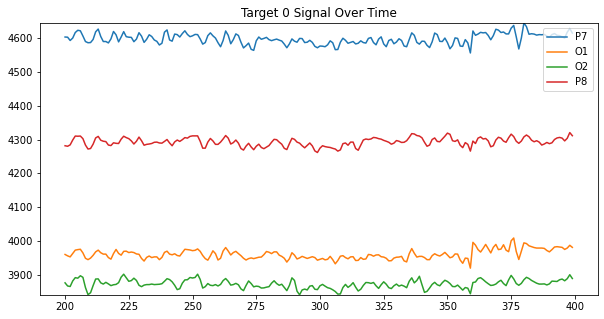

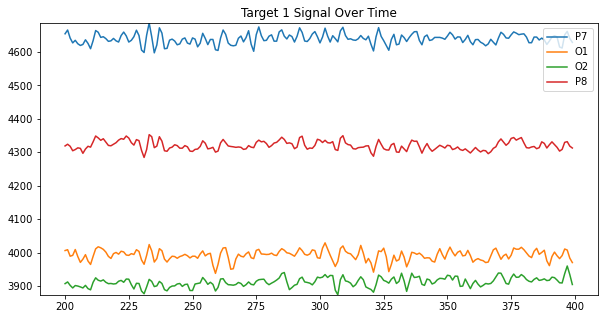

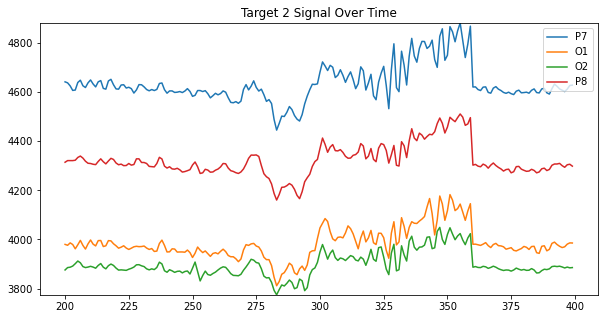

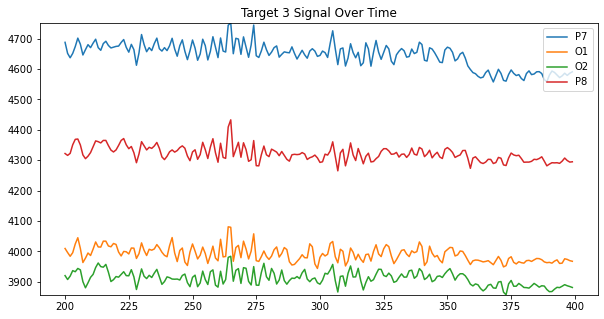

In [7]:
plot_time_all(start=200, end=400)

In [8]:
frequencies = [5.45, 8.57, 12.0, 15.0]
fir_filter_by_chunk(frequencies=frequencies, num_seconds=1)
# car_filter()

[4.45, 6.45]
[7.57, 9.57]
[11.0, 13.0]
[14.0, 16.0]


<ipython-input-5-16c85ff0f38e>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  targets[i][channel][row_index:row_index+128*num_seconds] = signal.convolve(np.array(targets[i][channel][row_index:row_index+128*num_seconds]), filt, mode='same')


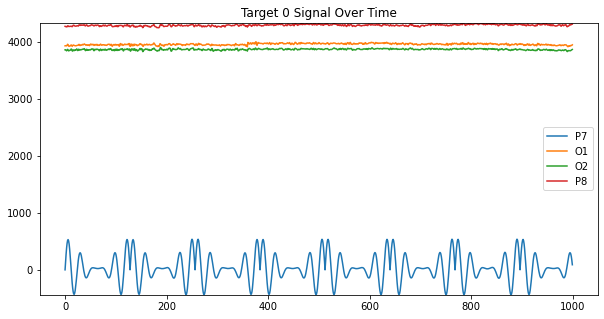

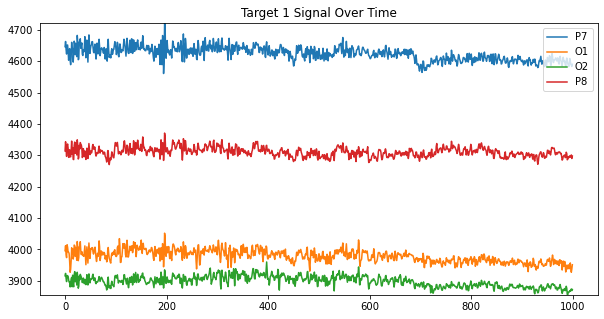

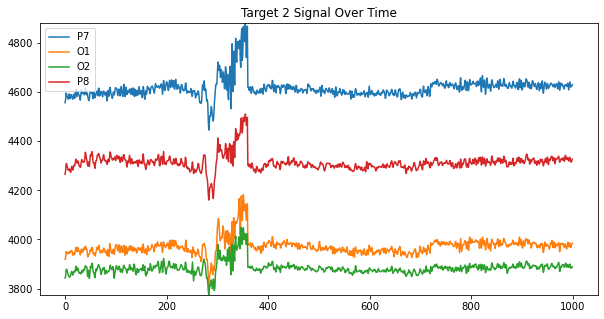

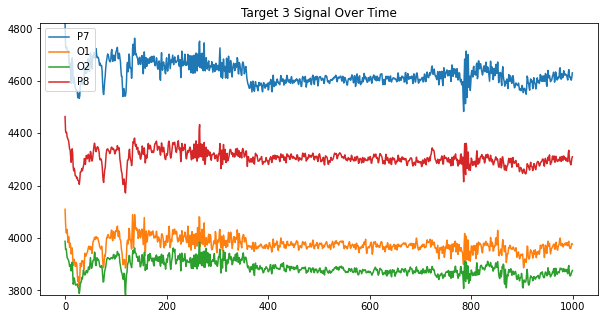

In [9]:
plot_time_all()